In [1]:
import pandas as pd
from bs4 import BeautifulSoup
from pathlib import Path
import os


In [2]:
from bs4 import BeautifulSoup
from pathlib import Path

def parse_xml_file(xml_path):
    """
    Fungsi ini membuka file XML dan mengambil seluruh teks yang relevan,
    terutama dari elemen seperti <sec>, <p>, dan bagian isi artikel.
    """
    with open(xml_path, 'r', encoding='utf-8') as f:
        soup = BeautifulSoup(f.read(), 'lxml')

    # Ambil semua paragraf
    paragraphs = soup.find_all('p')

    full_text = ""
    char_map = [] 

    current_pos = 0
    for para in paragraphs:
        text = para.get_text(separator=" ", strip=True)
        if text:
            start = current_pos
            full_text += text + "\n"
            end = current_pos + len(text)
            char_map.append({
                "start": start,
                "end": end,
                "text": text
            })
            current_pos = end + 1  # +1 untuk \n

    return full_text, char_map


In [ ]:

xml_file = Path("../Dataset/train/XML/10.1002_anie.201916483.xml") 
full_text, spans = parse_xml_file(xml_file)

print("Contoh Teks:")
print(full_text[:1000])
print("\nSpan Terdeteksi:")
print(spans[:3])


Contoh Teks:
The homoleptic pyrazolate complexes [Ce III 4 (Me 2 pz) 12 ] and [Ce IV (Me 2 pz) 4 ] 2 quantitatively insert CO 2 to give [Ce III 4 (Me 2 pz⋅CO 2 ) 12 ] and [Ce IV (Me 2 pz⋅CO 2 ) 4 ], respectively (Me 2 pz=3,5‐dimethylpyrazolato). This process is reversible for both complexes, as observed by in situ IR and NMR spectroscopy in solution and by TGA in the solid state. By adjusting the molar ratio, one molecule of CO 2 per [Ce IV (Me 2 pz) 4 ] complex could be inserted to give trimetallic [Ce 3 (Me 2 pz) 9 (Me 2 pz⋅CO 2 ) 3 (thf)]. Both the cerous and ceric insertion products catalyze the formation of cyclic carbonates from epoxides and CO 2 under mild conditions. In the absence of epoxide, the ceric catalyst is prone to reduction by the co‐catalyst tetra‐ n ‐butylammonium bromide (TBAB).
CO 2 sponges : Cerous and ceric pyrazolates have been demonstrated to insert carbon dioxide and afford the complexes [Ce III 4 (Me 2 pz⋅CO 2 ) 12 ] and [Ce IV (Me 2 pz⋅CO 2 ) 4 ]. The inser

In [4]:
from tqdm import tqdm

xml_dir = Path("../Dataset/train/XML/")
parsed_data = {}

for xml_file in tqdm(sorted(xml_dir.glob("*.xml"))):
    doc_id = xml_file.stem
    full_text, spans = parse_xml_file(xml_file)
    parsed_data[doc_id] = {
        "text": full_text,
        "spans": spans
    }


  0%|          | 0/400 [00:00<?, ?it/s]C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26224\1867568610.py:10: XMLParsedAsHTMLWarning: It looks like you're using an HTML parser to parse an XML document.

Assuming this really is an XML document, what you're doing might work, but you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the Python package 'lxml' installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.

If you want or need to use an HTML parser on this document, you can make this warning go away by filtering it. To do that, run this code before calling the BeautifulSoup constructor:

    from bs4 import XMLParsedAsHTMLWarning
    import warnings

    warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

  soup = BeautifulSoup(f.read(), 'lxml')
100%|██████████| 400/400 [01:09<00:00,  5.74it/s]


In [5]:
import json

with open("parsed_train_text.json", "w", encoding="utf-8") as f:
    json.dump(parsed_data, f, ensure_ascii=False, indent=2)


PREPROCESSING

In [6]:
labels_df = pd.read_csv("../Dataset/train_labels.csv")
labels_df.head()

,article_id,dataset_id,type
0,10.1002_2017jc013030,https://doi.org/10.17882/49388,Primary
1,10.1002_anie.201916483,Missing,Missing
2,10.1002_anie.202005531,Missing,Missing
3,10.1002_anie.202007717,Missing,Missing
4,10.1002_chem.201902131,Missing,Missing


In [8]:
import pandas as pd
# Filter hanya data yang memiliki type dan dataset_id bukan 'Missing'
df_valid = labels_df[(labels_df['type'] != 'Missing') & (labels_df['dataset_id'] != 'Missing')]

# Simpan ke file baru
output_path = '../Dataset/train_labels_valid.csv'
df_valid.to_csv(output_path, index=False)
print(f"✅ File tersimpan di: {output_path}")


✅ File tersimpan di: ../Dataset/train_labels_valid.csv


In [11]:
labels_df = pd.read_csv("../Dataset/train_labels_valid.csv")
labels_df.head()

,article_id,dataset_id,type
0,10.1002_2017jc013030,https://doi.org/10.17882/49388,Primary
1,10.1002_ece3.4466,https://doi.org/10.5061/dryad.r6nq870,Primary
2,10.1002_ece3.5260,https://doi.org/10.5061/dryad.2f62927,Primary
3,10.1002_ece3.6144,https://doi.org/10.5061/dryad.zw3r22854,Primary
4,10.1002_ece3.6303,https://doi.org/10.5061/dryad.37pvmcvgb,Primary


In [12]:
print(labels_df.columns)

Index(['article_id', 'dataset_id', 'type'], dtype='object')


MAPPING

In [13]:
# Normalisasi kolom
labels_df.columns = labels_df.columns.str.lower()
labels_df = labels_df[
    (labels_df['dataset_id'].str.lower() != 'missing') &
    (labels_df['type'].str.lower() != 'missing')
]
# Normalisasi
labels_df['article_id'] = labels_df['article_id'].str.strip().str.lower()
doc_id = xml_file.stem.strip().lower()

# Gabungkan hasil parsed XML dengan label
training_data = []

# Buat mapping article_id ke dataset_id dari data yang sudah dibersihkan
id_map = labels_df.drop_duplicates(subset=["article_id", "dataset_id"])[["article_id", "dataset_id"]]
id_map_dict = dict(zip(id_map["article_id"], id_map["dataset_id"]))



In [ ]:
training_data = []

for doc_id, content in parsed_data.items():
    article_text = content["text"]
    
    # Cari label berdasarkan doc_id
    matched = labels_df[labels_df['article_id'].str.contains(doc_id)]
    
    if not matched.empty:
        label = matched['type'].values[0].lower() 
        training_data.append({
            "text": article_text,
            "label": label
        })


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


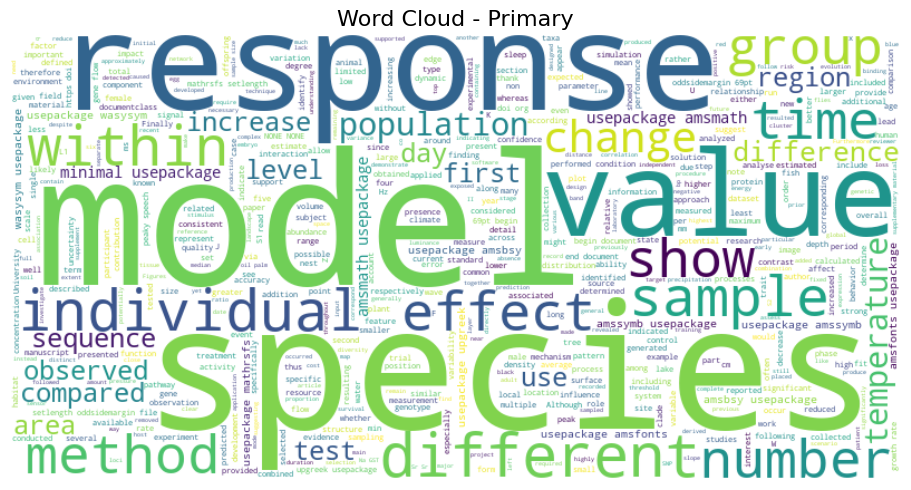

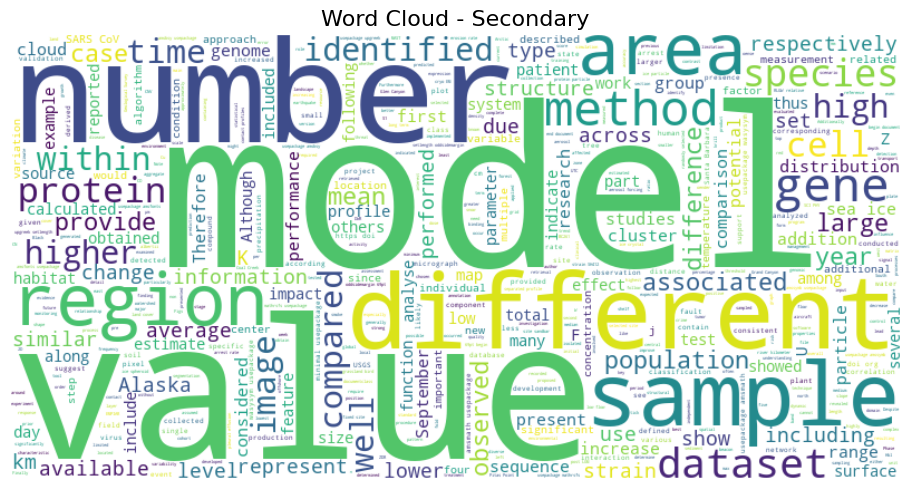

In [36]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

# Unduh stopwords NLTK jika belum ada
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Tambahkan stopword statis khusus ilmiah atau konteks domain
custom_stopwords = {
        'a', 'c', 'e', 'n', 'g', 'b', 'p', 'v', 'r', 'h', 'l', 'about', 'above', 'after',  
    'are', 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between',
    'both', 'but', 'by', 'could', 'did', 'do', 'does', 'doing', 'down', 'during', 'each',
    'few', 'for', 'from', 'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
    'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is',
    'it', 'its', 'itself', 'just', 'me', 'more', 'most', 'my', 'myself', 'no', 'nor',
    'not', 'now', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours',
    'ourselves', 'out', 'over', 'own', 'same', 'she', 'should', 'so', 'some', 'such',
    'than', 'that', 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there',
    'these', 'they', 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up',
    'very', 'was', 'we', 'were', 'what', 'when', 'where', 'which', 'while', 'who',
    'whom', 'why', 'with', 'you', 'your', 'yours', 'yourself', 'yourselves',
    'again', 'against', 'all', 'et', 'al', 'data', 'using', 'used', 'result', 
    'fig', 'figure', 'table', 'study', 'conclusion'
    'am', 'an', 'and', 'any', "result", "results", "shown", "based", "using", "used", "also",
    "analysis", "one", "two", "three", "may", "however", "found",
     'c', 'e', 'n', 'g', 'b', '12pt'
}

# Gabungkan semua stopwords
stop_words.update(custom_stopwords)

# Gabungkan teks berdasarkan label
primary_text = " ".join([d["text"] for d in training_data if d["label"].lower() == "primary"])
secondary_text = " ".join([d["text"] for d in training_data if d["label"].lower() == "secondary"])

# Fungsi untuk membuat WordCloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        stopwords=stop_words,
        max_words=500
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
# Tampilkan WordCloud untuk masing-masing label
generate_wordcloud(primary_text, "Word Cloud - Primary")
generate_wordcloud(secondary_text, "Word Cloud - Secondary")



In [16]:
df_train = pd.DataFrame(training_data)
print(df_train.head())


                                                text    label
0  The particulate backscattering coefficient vs ...  primary
1  Sex determination in Australian agamid lizards...  primary
2  Targeted capture and enrichment approaches hav...  primary
3  There is urgent need for effective and efficie...  primary
4  Polyploidy can cause variation in plant functi...  primary


In [17]:
import numpy
print(numpy.__version__)


1.26.4


In [18]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

# Encode
df_train['label'] = df_train['label'].map({'primary': 0, 'secondary': 1})
train_ds, val_ds = train_test_split(df_train, test_size=0.2, random_state=42)
train_ds = Dataset.from_pandas(train_ds)
val_ds = Dataset.from_pandas(val_ds)

def tokenize(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=512)

train_ds = train_ds.map(tokenize)
val_ds = val_ds.map(tokenize)

# Model
model = AutoModelForSequenceClassification.from_pretrained("allenai/scibert_scivocab_uncased", num_labels=2)


e:\UMB\Semester 6\DML\UAS\mdc_project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W0802 22:34:53.048000 26224 Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
e:\UMB\Semester 6\DML\UAS\mdc_project\.venv\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map: 100%|██████████| 34/34 [00:02<00:00, 13.24 examples/s]
e:\UMB\Semester 6\DML\UAS\mdc_project\.venv\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads alw

In [26]:
from accelerate import Accelerator
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="macro"),
        "precision": precision_score(labels, preds, average="macro"),
        "recall": recall_score(labels, preds, average="macro"),
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
)

trainer.train()


  0%|          | 0/99 [00:00<?, ?it/s]e:\UMB\Semester 6\DML\UAS\mdc_project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 10%|█         | 10/99 [04:40<43:00, 28.99s/it]

{'loss': 0.1081, 'grad_norm': 0.736835777759552, 'learning_rate': 1.797979797979798e-05, 'epoch': 0.3}


 20%|██        | 20/99 [09:31<38:49, 29.49s/it]

{'loss': 0.0378, 'grad_norm': 2.4186277389526367, 'learning_rate': 1.595959595959596e-05, 'epoch': 0.61}


 30%|███       | 30/99 [13:49<28:53, 25.13s/it]

{'loss': 0.2248, 'grad_norm': 0.0617474764585495, 'learning_rate': 1.3939393939393942e-05, 'epoch': 0.91}


                                               
 33%|███▎      | 33/99 [15:39<28:15, 25.68s/it]Checkpoint destination directory ./results\checkpoint-33 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 0.6342065930366516, 'eval_accuracy': 0.8529411764705882, 'eval_f1': 0.7622377622377623, 'eval_precision': 0.7797619047619048, 'eval_recall': 0.7486772486772486, 'eval_runtime': 33.2153, 'eval_samples_per_second': 1.024, 'eval_steps_per_second': 0.271, 'epoch': 1.0}


e:\UMB\Semester 6\DML\UAS\mdc_project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 40%|████      | 40/99 [18:33<25:10, 25.60s/it]

{'loss': 0.905, 'grad_norm': 3.7801241874694824, 'learning_rate': 1.191919191919192e-05, 'epoch': 1.21}


 51%|█████     | 50/99 [22:50<20:04, 24.58s/it]

{'loss': 0.0844, 'grad_norm': 22.468120574951172, 'learning_rate': 9.8989898989899e-06, 'epoch': 1.52}


 61%|██████    | 60/99 [27:13<18:05, 27.83s/it]

{'loss': 0.0388, 'grad_norm': 0.13597579300403595, 'learning_rate': 7.87878787878788e-06, 'epoch': 1.82}


                                               
 67%|██████▋   | 66/99 [30:13<13:24, 24.37s/it]Checkpoint destination directory ./results\checkpoint-66 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 0.996008574962616, 'eval_accuracy': 0.7352941176470589, 'eval_f1': 0.6150943396226416, 'eval_precision': 0.6105769230769231, 'eval_recall': 0.6216931216931216, 'eval_runtime': 33.1176, 'eval_samples_per_second': 1.027, 'eval_steps_per_second': 0.272, 'epoch': 2.0}


e:\UMB\Semester 6\DML\UAS\mdc_project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 71%|███████   | 70/99 [31:55<13:28, 27.89s/it]

{'loss': 0.0048, 'grad_norm': 0.059812840074300766, 'learning_rate': 5.858585858585859e-06, 'epoch': 2.12}


 81%|████████  | 80/99 [36:10<08:04, 25.52s/it]

{'loss': 0.0331, 'grad_norm': 0.23823338747024536, 'learning_rate': 3.8383838383838385e-06, 'epoch': 2.42}


 91%|█████████ | 90/99 [40:12<03:34, 23.86s/it]

{'loss': 0.0457, 'grad_norm': 0.0645943358540535, 'learning_rate': 1.8181818181818183e-06, 'epoch': 2.73}


                                               
100%|██████████| 99/99 [44:21<00:00, 23.95s/it]Checkpoint destination directory ./results\checkpoint-99 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 1.055934190750122, 'eval_accuracy': 0.7941176470588235, 'eval_f1': 0.7006289308176101, 'eval_precision': 0.6923076923076923, 'eval_recall': 0.7116402116402116, 'eval_runtime': 31.542, 'eval_samples_per_second': 1.078, 'eval_steps_per_second': 0.285, 'epoch': 3.0}


100%|██████████| 99/99 [44:25<00:00, 26.93s/it]

{'train_runtime': 2666.042, 'train_samples_per_second': 0.149, 'train_steps_per_second': 0.037, 'train_loss': 0.1632504031212643, 'epoch': 3.0}


TrainOutput(global_step=99, training_loss=0.1632504031212643, metrics={'train_runtime': 2666.042, 'train_samples_per_second': 0.149, 'train_steps_per_second': 0.037, 'train_loss': 0.1632504031212643, 'epoch': 3.0})

In [27]:
from sklearn.metrics import classification_report

# Dapatkan prediksi terhadap validation set
predictions = trainer.predict(val_ds)

# Ambil label asli dan prediksi
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(-1)

# Tampilkan classification report
print(classification_report(y_true, y_pred, target_names=["Primary", "Secondary"]))


e:\UMB\Semester 6\DML\UAS\mdc_project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 9/9 [00:28<00:00,  3.16s/it]

              precision    recall  f1-score   support

     Primary       0.89      0.93      0.91        27
   Secondary       0.67      0.57      0.62         7

    accuracy                           0.85        34
   macro avg       0.78      0.75      0.76        34
weighted avg       0.85      0.85      0.85        34



In [28]:
from bs4 import BeautifulSoup
from pathlib import Path

def extract_text_from_xml(xml_path):
    with open(xml_path, 'r', encoding='utf-8') as f:
        soup = BeautifulSoup(f.read(), "lxml")
    paragraphs = soup.find_all('p')
    text = "\n".join(p.get_text(separator=" ", strip=True) for p in paragraphs)
    return text


In [38]:
import pandas as pd
from transformers import TextClassificationPipeline
from pathlib import Path


# Buat mapping dari article_id ke dataset_id
id_map = labels_df.drop_duplicates(subset=["article_id", "dataset_id"])[["article_id", "dataset_id"]]
id_map_dict = dict(zip(id_map["article_id"], id_map["dataset_id"]))

# Pipeline prediksi
pipe = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
    truncation=True,
    max_length=512
)

def generate_dataset_url(article_id: str) -> str:
    base_doi = "https://doi.org/"
    base_figshare = "https://figshare.com/articles/dataset/"
    base_zenodo = "https://zenodo.org/record/"
    base_datadryad = "https://datadryad.org/stash/dataset/doi:"

    clean_id = article_id.replace("_", "/")  # 10.1002_anie.202007717 → 10.1002/anie.202007717

    
    if "10.5061" in clean_id:
        return base_datadryad + clean_id
    elif "10.5281" in clean_id:
        return base_zenodo + clean_id.split('/')[-1]
    elif "10.6084" in clean_id:
        return base_figshare + clean_id.split('/')[-1]
    else:
        return base_doi + clean_id

# Prediksi dan isi submission
submission_rows = []
test_dir = Path("../Dataset/test/XML")
row_id = 0

for xml_file in sorted(test_dir.glob("*.xml")):
    article_id = xml_file.stem
    text = extract_text_from_xml(xml_file)

    # Lakukan prediksi
    pred = pipe(text[:512])[0]
    label_num = int(max(pred, key=lambda x: x['score'])['label'].replace("LABEL_", "").replace("label_", ""))
    label = "Primary" if label_num == 0 else "Secondary"

    # Ambil dataset_id jika tersedia, jika tidak buat URL dari article_id
    matched_rows = [v for k, v in id_map_dict.items() if article_id in k]
    dataset_id = matched_rows[0] if matched_rows else generate_dataset_url(article_id)

    submission_rows.append({
        "article_id": article_id,
        "dataset_id": dataset_id,
        "type": label
    })
    row_id
# Simpan
submission_df = pd.DataFrame(submission_rows)
submission_df.to_csv("submission.csv", index=False)
print("✅ File 'submission.csv' selesai disimpan")


e:\UMB\Semester 6\DML\UAS\mdc_project\.venv\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26224\26735611.py:6: XMLParsedAsHTMLWarning: It looks like you're using an HTML parser to parse an XML document.

Assuming this really is an XML document, what you're doing might work, but you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the Python package 'lxml' installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.

If you want or need to use an HTML parser on this document, you can make this warning go away by filtering it. To do that, run this code before calling the BeautifulSoup constructor:

    from bs4 import XMLParse

✅ File 'submission.csv' selesai disimpan


In [30]:
submission_df = pd.DataFrame(submission_rows)

# Cek apakah masih ada 'Missing'
print("Masih ada label 'Missing'? ->", submission_df['dataset_id'].str.lower().str.contains("missing").any())


Masih ada label 'Missing'? -> False
